In [1]:
import numpy as np
import xgboost as xgb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from steveml.preprocessing import calculate_statistics, calculate_counts

%matplotlib inline

from sklearn.preprocessing import OneHotEncoder

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [109]:
def submit(preds, fname=None):
    from datetime import datetime, timedelta

    n = datetime.now() + timedelta(hours=3)
    submission = pd.read_csv('../sample_submission.csv')
    for i in range(3):
        submission['predict_' + str(i)] = preds[:, i]
    if fname is None:
        submission.to_csv('../submissions/submission ({0}).csv'.format(n.strftime("%d-%m-%Y %H:%M")), index=0)
    else:
        submission.to_csv('../submissions/submission ({0}).csv'.format(fname), index=0)

In [3]:
train = pd.read_csv('../data/final_train1.csv')
test = pd.read_csv('../data/final_test1.csv')

labels = np.loadtxt('../data/labels.csv').astype(int)

### Подтюним модели

In [112]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import scale

clf = LogisticRegression(C=1e-2, penalty='l1')
print cross_val_score(clf, scale(train), labels, scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1).mean()

-0.636592250398


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.2s finished


In [ ]:
%%time
params = {}
params['objective'] = 'multi:softprob'
params['num_class'] = 3
params['eta'] = 0.2 # 0.02
params['numrounds'] = 150 # 1100
params['eval_metric'] = 'mlogloss'
params['max_depth'] = 5 # 5
params['subsample'] = 1.0
params['colsample_bytree'] = 1.0 #.75 
params['nthread'] = 64
#params['min_child_weight'] = 15
#params['gamma'] = 1.0
params['seed'] = 1


xgtrain = xgb.DMatrix(train, labels)

t = xgb.cv(params, xgtrain, num_boost_round=params['numrounds'], nfold=5, show_stdv=0, seed=0, verbose_eval=10)
print t['test-mlogloss-mean'].min()
print t['test-mlogloss-mean'].argmin() + 1

In [76]:
%%time
params = {}
params['objective'] = 'multi:softprob'
params['num_class'] = 3
params['eta'] = 0.02 # 0.02
params['numrounds'] = 1500 # 1100
params['eval_metric'] = 'mlogloss'
params['max_depth'] = 5 # 5
params['subsample'] = 1.0
params['colsample_bytree'] = 1.0 #.75 
params['nthread'] = 64
#params['min_child_weight'] = 15
#params['gamma'] = 1.0
params['seed'] = 1


xgtrain = xgb.DMatrix(train, labels)

t = xgb.cv(params, xgtrain, num_boost_round=params['numrounds'], nfold=5, show_stdv=0, seed=0, verbose_eval=100)
print t['test-mlogloss-mean'].min()
print t['test-mlogloss-mean'].argmin() + 1

[0]	train-mlogloss:1.08383	test-mlogloss:1.08439
[100]	train-mlogloss:0.527111	test-mlogloss:0.568164
[200]	train-mlogloss:0.42005	test-mlogloss:0.486308
[300]	train-mlogloss:0.378318	test-mlogloss:0.461531
[400]	train-mlogloss:0.356095	test-mlogloss:0.451761
[500]	train-mlogloss:0.338759	test-mlogloss:0.445503
[600]	train-mlogloss:0.323423	test-mlogloss:0.441066
[700]	train-mlogloss:0.310284	test-mlogloss:0.437908
[800]	train-mlogloss:0.298288	test-mlogloss:0.435442
[900]	train-mlogloss:0.287201	test-mlogloss:0.433748
[1000]	train-mlogloss:0.276755	test-mlogloss:0.432181
[1100]	train-mlogloss:0.267358	test-mlogloss:0.431274
[1200]	train-mlogloss:0.258248	test-mlogloss:0.430699
[1300]	train-mlogloss:0.249997	test-mlogloss:0.430431
[1400]	train-mlogloss:0.242288	test-mlogloss:0.430236
0.430149
1458
CPU times: user 3h 40min 9s, sys: 20.3 s, total: 3h 40min 30s
Wall time: 3min 30s


In [100]:
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.cross_validation import cross_val_score

et = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, bootstrap=True
                          max_features=0.3, 
                          max_depth=25, 
                          criterion='gini',
                         )
print cross_val_score(et, train, labels, scoring='neg_log_loss', cv=5, verbose=1).mean()

-0.468576412101


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    8.3s finished


### Делаем предсказания моделей первого уровня

In [33]:
from sklearn.cross_validation import KFold
from sklearn.model_selection import cross_val_predict
from sklearn.base import BaseEstimator
from sklearn.ensemble import ExtraTreesClassifier

class ProbaEstimator(BaseEstimator):
    def __init__(self, estimator):
        self.estimator = estimator
    def fit(self, X, y):
        self.estimator.fit(X, y)
    def predict(self, X):
        return self.estimator.predict_proba(X)
    
et = ExtraTreesClassifier(n_estimators=2000, n_jobs=-1, bootstrap=True, max_features=0.3, 
                          max_depth=25, criterion='gini')

cv = KFold(train.shape[0], n_folds=5, random_state=42)
preds_train = cross_val_predict(et, train, labels, cv=cv, method='predict_proba')
preds_test = et.fit(train, labels).predict_proba(test)
np.savetxt('../stacking/et_train.csv', preds_train)
np.savetxt('../stacking/et_test.csv', preds_test)

In [65]:
from sklearn.cross_validation import KFold
from sklearn.model_selection import cross_val_predict

cv = KFold(train.shape[0], n_folds=5, random_state=42)

clf = LogisticRegression(C=1e-2, penalty='l1')

preds_train = cross_val_predict(clf, train, labels, cv=cv, method='predict_proba')
preds_test = clf.fit(train, labels).predict_proba(test)
np.savetxt('../stacking/lr_train.csv', preds_train)
np.savetxt('../stacking/lr_test.csv', preds_test)

In [ ]:
clf = xgb.XGBClassifier(learning_rate=0.2, n_estimators=150, objective='multi:softprob', 
                        max_depth=5, colsample_bytree=0.75)

preds_train = cross_val_predict(clf, train, labels, cv=cv, method='predict_proba')
preds_test = clf.fit(train, labels).predict_proba(test)
np.savetxt('../stacking/xgboost_maxdepth5_train.csv', preds_train)
np.savetxt('../stacking/xgboost_maxdepth5_test.csv', preds_test)

### Загружаем предсказания моделей первого уровня

In [83]:
et_preds = np.loadtxt('../stacking/et_train.csv')
xgb_preds = np.loadtxt('../stacking/xgboost_maxdepth5_train.csv')
lr_preds = np.loadtxt('../stacking/lr_train.csv')

train_stack = pd.DataFrame(np.hstack([et_preds, xgb_preds, ]))

et_preds_test = np.loadtxt('../stacking/et_test.csv')
xgb_preds_test = np.loadtxt('../stacking/xgboost_maxdepth5_test.csv')

test_stack = pd.DataFrame(np.hstack([et_preds_test, xgb_preds_test, ]))

0.4262
0.7576


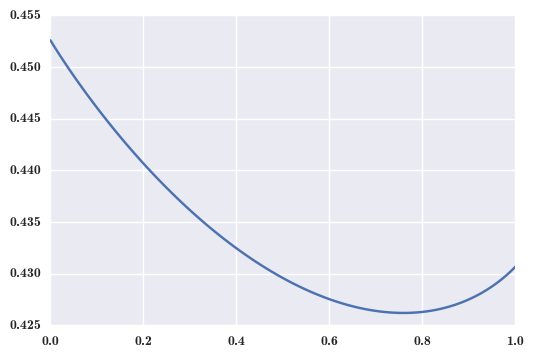

In [86]:
from sklearn.metrics import log_loss

weights = np.linspace(0, 1, 100)
scores = np.zeros_like(weights)
for index, alpha in enumerate(weights):
    preds = alpha * xgb_preds + (1-alpha) * et_preds
    scores[index] = log_loss(labels, preds)
plt.plot(weights, scores)
print "{0:.4f}".format(np.min(scores))
print "{0:.4f}".format(weights[np.argmin(scores)])

In [114]:
alpha = 0.7576
preds_blend = alpha * xgb_preds_test + (1-alpha) * et_preds_test
submit(preds_blend, "blend")

[0]	train-mlogloss:1.01129	test-mlogloss:1.01186
[10]	train-mlogloss:0.598026	test-mlogloss:0.603271
[20]	train-mlogloss:0.479781	test-mlogloss:0.488022
[30]	train-mlogloss:0.438956	test-mlogloss:0.449607
[40]	train-mlogloss:0.422171	test-mlogloss:0.435255
[50]	train-mlogloss:0.413843	test-mlogloss:0.429286
[60]	train-mlogloss:0.408612	test-mlogloss:0.42678
[70]	train-mlogloss:0.404693	test-mlogloss:0.425379
[80]	train-mlogloss:0.401486	test-mlogloss:0.424818
[90]	train-mlogloss:0.39863	test-mlogloss:0.424452
0.4243926
92


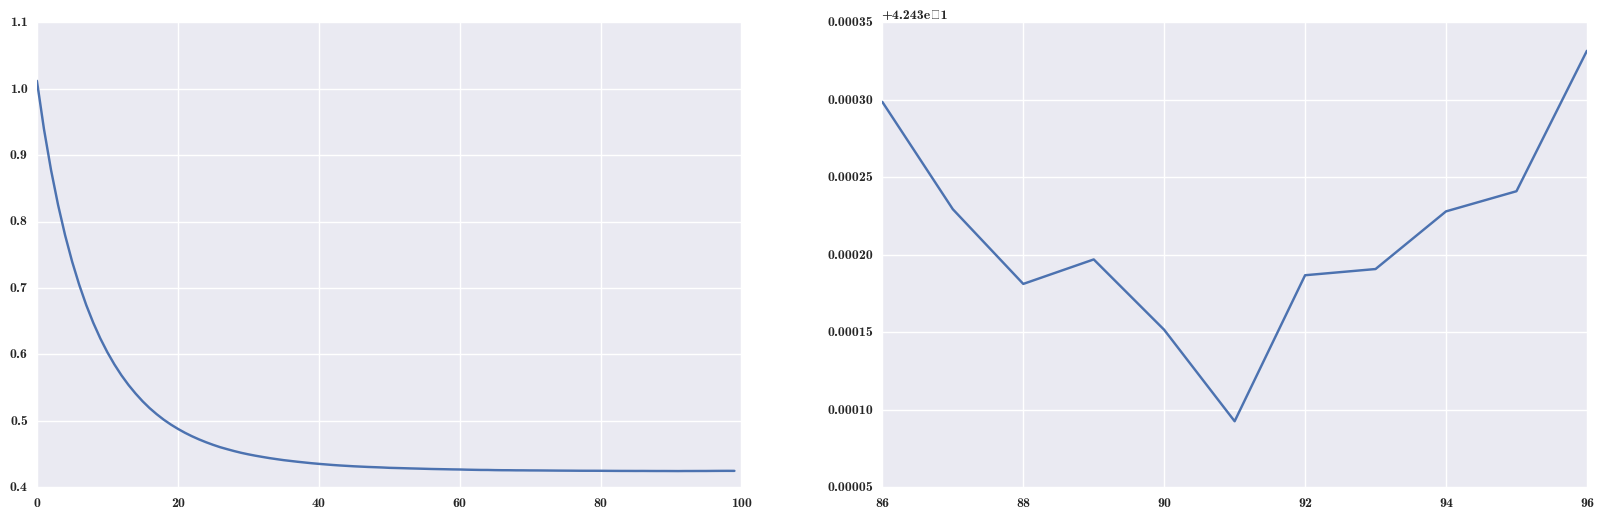

In [115]:
params = {}
params['objective'] = 'multi:softprob'
params['num_class'] = 3
params['eta'] = 0.1 # 0.02
params['numrounds'] = 100 
params['eval_metric'] = 'mlogloss'
params['max_depth'] = 2
params['subsample'] = 0.75
params['min_child_weight'] = 1
params['nthread'] = 64
params['gamma'] = 1.5
params['seed'] = 1

xgtrain_stack = xgb.DMatrix(train_stack.values, labels)

t = xgb.cv(params, xgtrain_stack, num_boost_round=params['numrounds'], nfold=5, verbose_eval=10, show_stdv=0, seed=0)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
ax1.plot(t.index, t['test-mlogloss-mean'])
print t['test-mlogloss-mean'].min()
print t['test-mlogloss-mean'].argmin() + 1

best_iter = t['test-mlogloss-mean'].argmin()
_ = ax2.plot(t.index[best_iter-5:best_iter+6], t.loc[best_iter-5:best_iter+5, 'test-mlogloss-mean'])
# .4319

In [117]:
model = xgb.train(params, xgtrain_stack, num_boost_round=92)

xgtest_stack = xgb.DMatrix(test_stack.values)
preds = model.predict(xgtest_stack)
submit(preds, 'stacking')

In [105]:
from sklearn.base import BaseEstimator
from sklearn.cross_validation import cross_val_score, KFold

estim = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=2, 
                          subsample=0.75, gamma=1.5, objective='multi:softprob')
cv = KFold(train.shape[0], n_folds=5, random_state=42)
print cross_val_score(estim, train_stack, labels, cv=cv, scoring='neg_log_loss').mean()

-0.424663879246


In [118]:
xgtest_stack = xgb.DMatrix(test_stack.values)
preds_20x_seed = np.zeros(shape=(test.shape[0], 3))

iterations = 20

for iter in range(iterations):
    params['seed'] = iter
    model = xgb.train(params, xgtrain_stack, num_boost_round=92)
    preds_20x_seed += model.predict(xgtest_stack)
    
preds_20x_seed = preds_20x_seed / iterations

submit(preds_20x_seed, "stacking_20x_seed")    

In [122]:
preds_average = (preds_blend + preds_20x_seed) / 2
submit(preds_average, 'average')